<a href="https://colab.research.google.com/github/DABallentine/knowledge_discovery_charlotte/blob/Kevin/311_Calls_Analysis_10_15_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discovering Knowledge for the City of Charlotte, NC
This project is a course requirement for DSBA-6162, Knowledge Discovery in Databases, at UNCC for the Fall semester, 2021.

<b>Team Members:</b> <br>
Naomi Thammadi <br>
Kevin Gharavizadeh <br>
Imad Ahmad <br>
Dustin Ballentine <br>

<h2> Project Motivation </h2>
The city of Charlotte has, like many cities, made large volumes of data open to the public in an online repository. This open data provides substantial potential for the city to benefit from knowledge discovery and insights generated by members of the public, such as ourselves. Service requests dialed to 311 represent a large opportunity to delve into the needs of the population and potentially extract useful trends that could allow the city to improve its service to its citizens. The goal of this project is to explore and uncover exactly those trends in the hope that the knowledge we discover may be used by the city to improve the quality of life of our families, friends, and neighbors.

<h2> Research Question(s) </h2>
<b>Do different areas within the city of Charlotte experience higher recurrence of any type of 311 service request than other areas, and do those areas correlate with red-line districts or other known demographic or socioeconomic profiles?</b>

<h2> Data Resources </h2>

<a href="https://data.charlottenc.gov/datasets/charlotte::service-requests-311/about"> 311 Service Requests </a> retrieved 30 September, 2021. 

<a href= "https://data.charlottenc.gov/datasets/census-household-income-block-groups/explore?location=35.259200%2C-80.807850%2C10.90"> Household Income </a> retrieved 12 October, 2021. 

<h2> Data Survey </h2>

In [1]:
#install packages, and download a few new ones 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')

import descartes

!pip install geopandas 
import geopandas as gpd

from shapely.geometry import Point, Polygon

%matplotlib inline

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 36 kB/s 
     |████████████████████████████████| 6.3 MB 24.3 MB/s 


In [2]:
#mount and connect my drive to access data files 

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#311 CSV file 
requests = pd.read_csv('/content/gdrive/MyDrive/Data/Service_Requests_311.csv')


In [4]:
requests.head()

,X,Y,OBJECTID,DEPARTMENT,DIVISION,REQUEST_NO,FISCAL_YEAR,FISCAL_MONTH,REQUEST_TYPE,RECEIVED_DATE,INTERNAL_FIELD_OBSERVATION,TITLE,CMPD_DIVISION,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,STREET_DIRECTION,STREET_NAME,STREET_TYPE,CITY,STATE,ZIP_CODE,FULL_ADDRESS,X_COORD,Y_COORD,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,GlobalID,PID,Shape
0,1.458251e+06,508075.000119,1,Solid Waste Services,Sanitation,6402056,2017,05-Nov,NON_RECYCLABLE ITEMS,2016/11/07 14:25:00+00,N,NON_RECYCLABLE ITEMS,NaN,215.0,3601.0,NaN,KNAPDALE,LN,CHARLOTTE,NC,28226.0,"3601 KNAPDALE LN, CHARLOTTE, NC 28226",1458251.0,508075.0,35.132444,-80.812089,NaN,{35439C7B-D8E4-4296-9119-8673B1D5A7C8},20904304,NaN
1,1.468687e+06,587225.999953,2,Housing and NBHD Serv,311 Partner Liaison,6402064,2017,05-Nov,UTILITY VERIFICATION LTR,2016/11/07 14:28:00+00,N,UTILITY VERIFICATION LTR,NaN,265.0,4124.0,NaN,SILVERMERE,WY,CHARLOTTE,NC,28269.0,"4124 SILVERMERE WY, CHARLOTTE, NC 28269",1468687.0,587226.0,35.350408,-80.781941,NaN,{3B4A2DC0-8886-4E8E-95E6-4F426C4E08E2},02731251,NaN
2,1.471481e+06,562512.999839,3,Solid Waste Services,Sanitation,6402082,2017,05-Nov,NON_RECYCLABLE ITEMS,2016/11/07 14:34:00+00,N,Non-recyclable Items,NaN,103.0,523.0,NaN,GRAHAM MEADOW,DR,CHARLOTTE,NC,28213.0,"523 GRAHAM MEADOW DR, CHARLOTTE, NC 28213",1471481.0,562513.0,35.282654,-80.771094,NaN,{C3E4CF76-7630-4356-8216-428445A0903F},08917486,NaN
3,1.438992e+06,568604.000124,4,Solid Waste Services,Sanitation,6402103,2017,05-Nov,MISSED RECYCLING,2016/11/07 14:41:00+00,N,MISSED RECYCLING,NaN,158.0,1801.0,NaN,CRANDON,DR,CHARLOTTE,NC,28216.0,"1801 CRANDON DR, CHARLOTTE, NC 28216",1438992.0,568604.0,35.297745,-80.880327,NaN,{FC3B4CD8-1131-42B4-A37E-8CA448855B24},03925515,NaN
4,NaN,NaN,5,Transit,Transit/Operations,6402111,2017,05-Nov,CITIZEN FEEDBACK,2016/11/07 14:44:00+00,N,CITIZEN FEEDBACK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{E0166346-2381-40E1-80A0-2ECA4FB6CB27},NaN,NaN


In [6]:
requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631510 entries, 0 to 1631509
Data columns (total 30 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   X                           1559084 non-null  float64
 1   Y                           1559084 non-null  float64
 2   OBJECTID                    1631510 non-null  int64  
 3   DEPARTMENT                  1631510 non-null  object 
 4   DIVISION                    1623095 non-null  object 
 5   REQUEST_NO                  1631510 non-null  int64  
 6   FISCAL_YEAR                 1631510 non-null  int64  
 7   FISCAL_MONTH                1631510 non-null  object 
 8   REQUEST_TYPE                1631510 non-null  object 
 9   RECEIVED_DATE               1631510 non-null  object 
 10  INTERNAL_FIELD_OBSERVATION  1631510 non-null  object 
 11  TITLE                       1631510 non-null  object 
 12  CMPD_DIVISION               45672 non-null    object 
 1

**Variable Selection** 
Following Variables are either: Redundant, large amouunt of NaN Values. 

X 

Y

Fiscal_Year

Fiscal_Month

CMPD_Division

Street_Directions

Street_name

Street_Type

City

State 

Council_District 

Global_ID

PID 

Shape 

In [7]:
requests.drop(requests.iloc[:, [0,1,12,15,16,17,18,19,26,27,28,29]], axis=1, inplace =True)
requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631510 entries, 0 to 1631509
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   OBJECTID                    1631510 non-null  int64  
 1   DEPARTMENT                  1631510 non-null  object 
 2   DIVISION                    1623095 non-null  object 
 3   REQUEST_NO                  1631510 non-null  int64  
 4   FISCAL_YEAR                 1631510 non-null  int64  
 5   FISCAL_MONTH                1631510 non-null  object 
 6   REQUEST_TYPE                1631510 non-null  object 
 7   RECEIVED_DATE               1631510 non-null  object 
 8   INTERNAL_FIELD_OBSERVATION  1631510 non-null  object 
 9   TITLE                       1631510 non-null  object 
 10  NEIGHBORHOOD_PROFILE_AREA   1559062 non-null  float64
 11  BLOCK_NO                    1587157 non-null  float64
 12  ZIP_CODE                    1586427 non-null  float64
 1

In [ ]:
requests.head()

,OBJECTID,DEPARTMENT,DIVISION,REQUEST_NO,REQUEST_TYPE,RECEIVED_DATE,INTERNAL_FIELD_OBSERVATION,TITLE,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,ZIP_CODE,FULL_ADDRESS,X_COORD,Y_COORD,LATITUDE,LONGITUDE
0,1,Solid Waste Services,Sanitation,6402056,NON_RECYCLABLE ITEMS,2016/11/07 14:25:00+00,N,NON_RECYCLABLE ITEMS,215.0,3601.0,28226.0,"3601 KNAPDALE LN, CHARLOTTE, NC 28226",1458251.0,508075.0,35.132444,-80.812089
1,2,Housing and NBHD Serv,311 Partner Liaison,6402064,UTILITY VERIFICATION LTR,2016/11/07 14:28:00+00,N,UTILITY VERIFICATION LTR,265.0,4124.0,28269.0,"4124 SILVERMERE WY, CHARLOTTE, NC 28269",1468687.0,587226.0,35.350408,-80.781941
2,3,Solid Waste Services,Sanitation,6402082,NON_RECYCLABLE ITEMS,2016/11/07 14:34:00+00,N,Non-recyclable Items,103.0,523.0,28213.0,"523 GRAHAM MEADOW DR, CHARLOTTE, NC 28213",1471481.0,562513.0,35.282654,-80.771094
3,4,Solid Waste Services,Sanitation,6402103,MISSED RECYCLING,2016/11/07 14:41:00+00,N,MISSED RECYCLING,158.0,1801.0,28216.0,"1801 CRANDON DR, CHARLOTTE, NC 28216",1438992.0,568604.0,35.297745,-80.880327
4,5,Transit,Transit/Operations,6402111,CITIZEN FEEDBACK,2016/11/07 14:44:00+00,N,CITIZEN FEEDBACK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
requests.describe()

,OBJECTID,REQUEST_NO,FISCAL_YEAR,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,ZIP_CODE,X_COORD,Y_COORD,LATITUDE,LONGITUDE
count,1.631510e+06,1.631510e+06,1.631510e+06,1.559062e+06,1.587157e+06,1.586427e+06,1.559084e+06,1.559084e+06,1.559077e+06,1.559077e+06
mean,8.158046e+05,7.321723e+06,2.019125e+03,2.169880e+02,5.080012e+03,2.821764e+04,1.455878e+06,5.373895e+05,3.521283e+01,-8.082195e+01
std,4.710376e+05,6.148555e+05,1.457172e+00,1.245330e+02,1.653287e+04,6.255646e+02,2.278111e+04,3.046626e+04,8.379533e-02,8.065106e-02
min,1.000000e+00,5.472783e+06,2.017000e+03,2.000000e+00,1.000000e+00,3.000000e+00,1.384994e+06,4.644550e+05,3.501230e+01,-8.556829e+01
25%,4.078782e+05,6.781959e+06,2.018000e+03,1.130000e+02,2.000000e+03,2.821000e+04,1.441290e+06,5.150110e+05,3.515058e+01,-8.087012e+01
50%,8.157555e+05,7.326774e+06,2.019000e+03,2.240000e+02,4.322000e+03,2.821500e+04,1.457596e+06,5.395110e+05,3.521909e+01,-8.081576e+01
75%,1.223807e+06,7.862086e+06,2.020000e+03,3.360000e+02,7.332000e+03,2.826200e+04,1.472597e+06,5.590980e+05,3.527270e+01,-8.076559e+01
max,1.631684e+06,8.370087e+06,2.022000e+03,4.750000e+02,8.514135e+06,9.890800e+04,1.534475e+06,6.487410e+05,3.551843e+01,-7.607136e+01


In [ ]:
#Checking for missing data 
requests.isnull().sum()

OBJECTID                          0
DEPARTMENT                        0
DIVISION                       8415
REQUEST_NO                        0
REQUEST_TYPE                      0
RECEIVED_DATE                     0
INTERNAL_FIELD_OBSERVATION        0
TITLE                             0
NEIGHBORHOOD_PROFILE_AREA     72448
BLOCK_NO                      44353
ZIP_CODE                      45083
FULL_ADDRESS                   7168
X_COORD                       72426
Y_COORD                       72426
LATITUDE                      72433
LONGITUDE                     72433
dtype: int64

In [ ]:
#drop missing values 
#requests = requests.dropna()

In [9]:
requests.shape

(1631510, 18)

In [63]:
#Observe the top request types, department, and division. 
#Identify any large differences between department and division? 

print(requests['REQUEST_TYPE'].value_counts().head(30))



NON_RECYCLABLE ITEMS         831737
RECYCLABLE ITEMS             199452
HNS HEALTH AND SANITATION     85031
CART REPAIR-GARBAGE           36541
MISSED RECYCLING              27471
SW DOCUMENT GARBAGE           26729
311 DOCUMENT                  25395
CDOT STREETLIGHT REPAIR       19216
SW DOCUMENT RECYCLING         17932
DEAD ANIMAL COLLECTION        16727
CART ISSUE/MISSING CART       15121
TIRES                         13577
SW DOCUMENT YARD WASTE        13186
CART DELIVERY RECYCLING       11835
COMPLAINT                     11788
ZONING/COMPLAINT/ INSPECT     11767
CART(S) DEL- NEW BUILD        11324
CART ONLY DELIVER-GARB        11235
CART REPAIR-RECYCLE            9933
ZON GENERAL INFO  INQUIRY      9805
CDOT POTHOLE REPAIR            9416
HNS HOUSING                    8405
CART PURCHASE 2ND-GARBAGE      8077
MISSED GARBAGE                 7330
CDOT STREET SIGN REP/REPL      7260
PARKING ON LAWN WORKDAYS       6956
STREET SWEEPING/FLUSHING       6824
GRAFFITI                    

In [71]:
requests.REQUEST_TYPE.value_counts().TIRES
#Confirm how to check specific value count for something with spaces in between 

13577

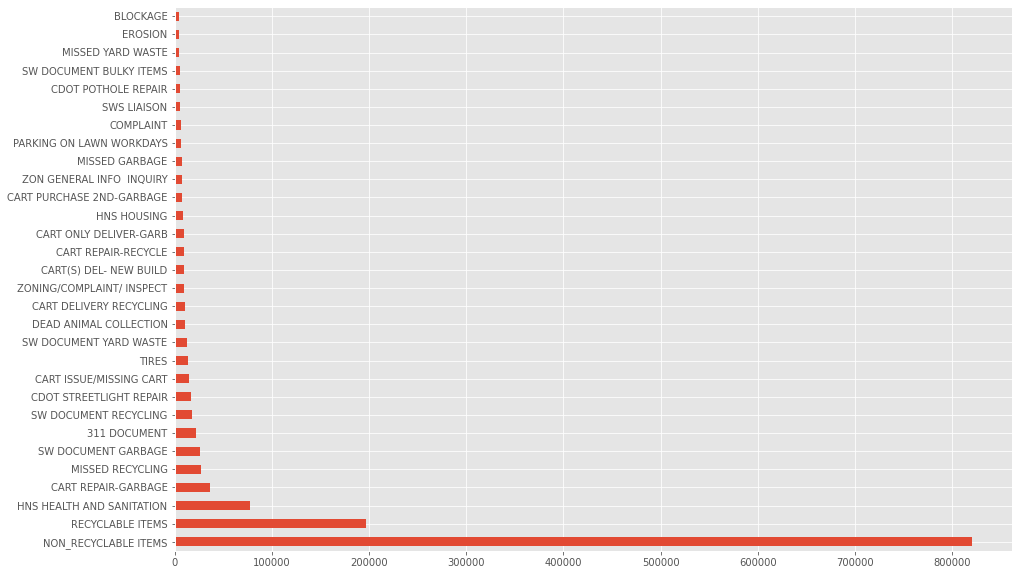

In [ ]:
requests['REQUEST_TYPE'].value_counts().head(30).plot(kind='barh', figsize=(15,10))

Request Types Taper off very dramatically, review the bottom requests 

In [13]:
print("Bottom 30 categories by volume")
print(requests['REQUEST_TYPE'].value_counts().tail(30).sort_values())

Bottom 30 categories by volume
SW FIELD OBSERVED TO CI       1
BUS STOP-REMOVE TRASH CAN     1
DISABILITY ACT                1
COMPLEX PROBLEM               1
SW EXCESSIVE STORM-SW USE     1
ON CALL - SWS SPEC SERV       1
UT/LANDSCAPE                  1
SWS MLTFMLY FIELD OBSERVE     1
UT/MANDATORY                  1
SW REMINDER BULKY-SW USE      2
SW REMINDER GARB-SW USE       4
NEW SVC BUSINESS GARBAGE      5
CART REPAIR-BUSN GARB         6
SW ESCALATION REQUEST         6
BUS STOP-TRASH CAN MISC       6
OPINION                       7
CART DELIVERY BUSN GARB       7
BULKY ITEM SCHEDULE           8
BUS FACILITIES MAINT          8
LAND DEVELOPMENT INQUIRY      8
UT RATE CHANGE                9
SMOKING VEHICLE REPORT        9
CART ONLY DELIVER-RECY       10
BUS STOP-FULL TRASH  CAN     10
MUD IN THE STREET            10
PARK & REC REFUND/CANCEL     11
DISABLED INSPECTION (SWS)    12
SWS CART RETIRE REVIEW       12
ZON APPEALS/CITATIONS INQ    14
CWP REQUEST-HIGH PRIORITY    16
Name: REQ

In [ ]:
requests['REQUEST_TYPE'].unique().tolist()

['NON_RECYCLABLE ITEMS',
 'UTILITY VERIFICATION LTR',
 'MISSED RECYCLING',
 'CWP REQUEST',
 'RECYCLABLE ITEMS',
 'CART REPAIR-GARBAGE',
 '311 DOCUMENT',
 'HNS HEALTH AND SANITATION',
 'ZON DAYCARE/CHILDCARE INQ',
 'CDOT STREETLIGHT REPAIR',
 'ZON SIGNS INQUIRY',
 'CART ISSUE/MISSING CART',
 'CART REPAIR-RECYCLE',
 'SW DOCUMENT BULKY ITEMS',
 'TIRES',
 'LANDSCAPE TREES',
 'CART DELIVERY RECYCLING',
 'TAX BILL INQUIRY',
 'CART PURCHASE 2ND-GARBAGE',
 'FIELD OBSERVED PROBLEM',
 'SW DOCUMENT YARD WASTE',
 'SWS CART SHIPMT REVIEW',
 'ZONGROUP/BOARDING HOMES',
 'INVALID/NEW SW ADDRESS',
 'FLOODING',
 'SW DOCUMENT GARBAGE',
 'DEAD ANIMAL COLLECTION',
 'SW DOCUMENT RECYCLING',
 'ZON RESIDENTIAL PERMITS',
 'INVESTIGATE/CONTACT RECY',
 'CART(S) DEL- NEW BUILD',
 'HNS HOUSING',
 'CART ONLY DELIVER-GARB',
 'CART PURCHASE 2ND-RECYCLE',
 'CART PICKUP-RECYCLE',
 '3-1-1 ESCALATION REQUEST',
 'CDOT TRAFFIC CALMING',
 'ZON SUPERVISORY COMPLAINT',
 'CDOT GRATE DAMAGE/REPLACE',
 'INVESTIGATE/CONTACT BULKY

In [ ]:
print("Top 30 departments by volume:\n")
print(requests['DEPARTMENT'].value_counts().head(30))



Top 30 departments by volume:

Solid Waste Services     1291189
Housing and NBHD Serv     158678
Transportation             45209
Storm Water Services       16423
UT-Utilities                6090
Police                      4359
Eng & Prop Mgmt/City        3489
Mecklenburg County          1249
Finance/City                 906
Planning/City                463
City Manager                 196
Shared Services               55
Transit                       26
Name: DEPARTMENT, dtype: int64


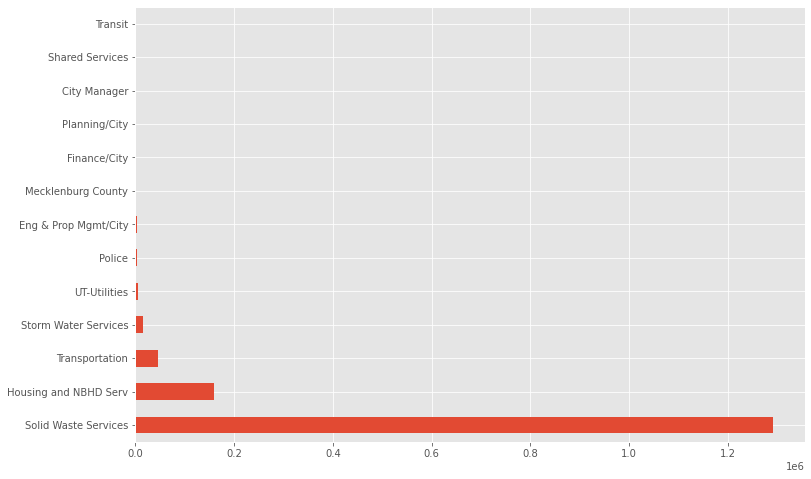

In [ ]:
requests['DEPARTMENT'].value_counts().head(30).plot(kind='barh', figsize=(12,8))

In [ ]:
print("Top 30 Divisions by volume:\n")
print(requests['DIVISION'].value_counts().head(30))

Top 30 Divisions by volume:

Sanitation                   1061284
HNS Code Enforcement          131997
Carts - Otto                   98079
Multifamily (Bulky)            87730
CDOT Customer Service          29433
311 Partner Liaison            26538
Special Services               18928
Street Maintenance             15776
Storm Water- City              13870
SWS Carts Admin                 9626
Multifamily (Garb / Recy)       5265
UT-Administration               3533
Landscape Manage./City          3475
SW Contract Monitors            2900
Police/COVID Response           2754
Solid Waste Admin               2747
Storm Water- County             2553
SW Addresses                    1874
SWS Cust Svc Liaison Team       1869
311 Utility Escalation          1798
Animal Control                  1451
CWP Resolution Team              870
UT-Field Operations              651
Tax Assessor Office              562
SW Multi-Family                  558
Land Development/City            463
Park and 

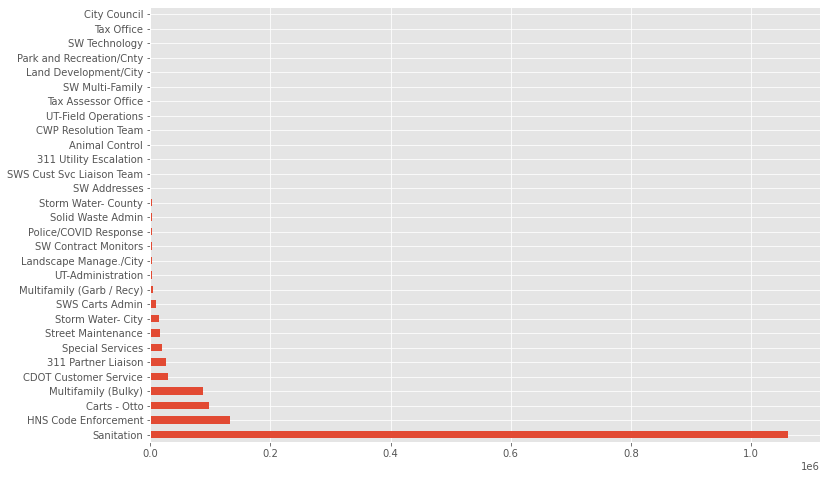

In [ ]:
requests['DIVISION'].value_counts().head(30).plot(kind='barh', figsize=(12,8))

In [16]:
requests['FULL_ADDRESS'].value_counts().head(50)

 PROVIDENCE RD, CHARLOTTE, NC  28211             603
8301 SHARON LAKES RD, CHARLOTTE, NC  28210       563
 E W T HARRIS BV, CHARLOTTE, NC  28213           419
 REA RD, CHARLOTTE, NC  28277                    413
 PARK RD, CHARLOTTE, NC  28210                   412
 S TRYON ST, CHARLOTTE, NC  28262                399
 N TRYON ST, CHARLOTTE, NC  28202                366
 CARMEL RD, CHARLOTTE, NC  28226                 350
1120 MARBLE ST, CHARLOTTE, NC  28208             327
3642 HUYTON CT, CHARLOTTE, NC  28215             320
5015 CHERRYCREST LN, CHARLOTTE, NC  28217        310
4624 SHARON CHASE DR, CHARLOTTE, NC  28215       309
5200 AMITY SPRINGS DR, CHARLOTTE, NC  28212      306
1357 SHARON RD WEST, CHARLOTTE, NC  28210        305
6619 YATESWOOD DR, CHARLOTTE, NC  28212          301
2868 HEATHSTEAD PL, CHARLOTTE, NC  28210         298
1207 KELSTON PL, CHARLOTTE, NC  28212            298
201 S HOSKINS RD, CHARLOTTE, NC  28208           298
7139 WINDING CEDAR TL, CHARLOTTE, NC  28212   

In [17]:
#SHP visual basemap file 
charlotte_map = gpd.read_file('/content/gdrive/MyDrive/Data/mecklenburgcounty_boundary/MecklenburgCounty_Boundary.shp')

In [18]:
#SHP Visual with zipcode boundaries 
charlotte_zipcode_map = gpd.read_file('/content/gdrive/MyDrive/Data/zipcode/Zipcode.shp')

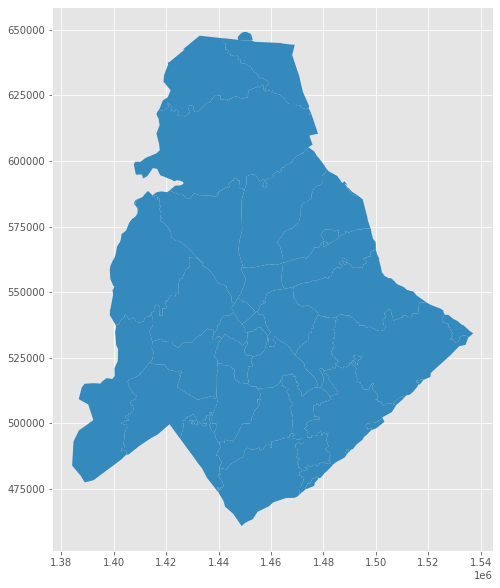

In [19]:
#This map seems better. Perhaps we can get it to change the colors for each zone 

fig, ax = plt.subplots(figsize = (10,10))
charlotte_zipcode_map.plot(ax= ax)

In [20]:
#Look at the geometry of our shape file to see what coordinate system to use 
charlotte_zipcode_map.head(50)

,objectid_1,zip,po_name,shape_Leng,shape_Area,geometry
0,1,28269,CHARLOTTE,153090.308851,8.290439e+08,"POLYGON ((1474271.666 605253.751, 1476487.623 ..."
1,2,28075,HARRISBURG,10472.133974,2.431967e+06,"POLYGON ((1489318.124 589639.188, 1489488.625 ..."
2,3,28206,CHARLOTTE,70381.941476,1.956278e+08,"POLYGON ((1464573.491 560419.792, 1464454.104 ..."
3,4,28214,CHARLOTTE,175023.225545,9.583438e+08,"POLYGON ((1414807.123 586940.379, 1414954.627 ..."
4,5,28120,MOUNT HOLLY,7280.707178,1.026388e+06,"POLYGON ((1408118.000 583191.500, 1407986.125 ..."
5,6,28120,MOUNT HOLLY,9030.404301,7.022050e+05,"POLYGON ((1408351.250 578936.625, 1408611.625 ..."
6,7,28208,CHARLOTTE,130752.118943,6.033690e+08,"POLYGON ((1437644.104 556907.910, 1438927.856 ..."
7,8,28205,CHARLOTTE,101303.709240,3.396873e+08,"POLYGON ((1468497.625 547893.375, 1468575.563 ..."
8,9,28202,CHARLOTTE,30773.798908,4.981543e+07,"POLYGON ((1447492.752 547889.876, 1448152.516 ..."
9,10,28203,CHARLOTTE,48420.358041,8.975605e+07,"POLYGON ((1446268.503 541410.940, 1446321.699 ..."


In [21]:
#CRS referes to coordinatae reference system. CRS tells python how these coordinates relate to a place on earth 
#We need to convert our pandas dataframe into a "geo dataframe"
crs= {'init': 'epsg:4326'}
requests.head()

,OBJECTID,DEPARTMENT,DIVISION,REQUEST_NO,FISCAL_YEAR,FISCAL_MONTH,REQUEST_TYPE,RECEIVED_DATE,INTERNAL_FIELD_OBSERVATION,TITLE,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,ZIP_CODE,FULL_ADDRESS,X_COORD,Y_COORD,LATITUDE,LONGITUDE
0,1,Solid Waste Services,Sanitation,6402056,2017,05-Nov,NON_RECYCLABLE ITEMS,2016/11/07 14:25:00+00,N,NON_RECYCLABLE ITEMS,215.0,3601.0,28226.0,"3601 KNAPDALE LN, CHARLOTTE, NC 28226",1458251.0,508075.0,35.132444,-80.812089
1,2,Housing and NBHD Serv,311 Partner Liaison,6402064,2017,05-Nov,UTILITY VERIFICATION LTR,2016/11/07 14:28:00+00,N,UTILITY VERIFICATION LTR,265.0,4124.0,28269.0,"4124 SILVERMERE WY, CHARLOTTE, NC 28269",1468687.0,587226.0,35.350408,-80.781941
2,3,Solid Waste Services,Sanitation,6402082,2017,05-Nov,NON_RECYCLABLE ITEMS,2016/11/07 14:34:00+00,N,Non-recyclable Items,103.0,523.0,28213.0,"523 GRAHAM MEADOW DR, CHARLOTTE, NC 28213",1471481.0,562513.0,35.282654,-80.771094
3,4,Solid Waste Services,Sanitation,6402103,2017,05-Nov,MISSED RECYCLING,2016/11/07 14:41:00+00,N,MISSED RECYCLING,158.0,1801.0,28216.0,"1801 CRANDON DR, CHARLOTTE, NC 28216",1438992.0,568604.0,35.297745,-80.880327
4,5,Transit,Transit/Operations,6402111,2017,05-Nov,CITIZEN FEEDBACK,2016/11/07 14:44:00+00,N,CITIZEN FEEDBACK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#we now need to create "points", points describe out long and lat into a data point. 
#make sure to always specify longitude column before lat

In [22]:
geometry= [Point(xy) for xy in zip(requests['X_COORD'], requests['Y_COORD'])]
geometry[:3]

In [23]:
geo_requests = gpd.GeoDataFrame(requests,
                                  crs=crs,
                                  geometry= geometry)
geo_requests.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,OBJECTID,DEPARTMENT,DIVISION,REQUEST_NO,FISCAL_YEAR,FISCAL_MONTH,REQUEST_TYPE,RECEIVED_DATE,INTERNAL_FIELD_OBSERVATION,TITLE,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,ZIP_CODE,FULL_ADDRESS,X_COORD,Y_COORD,LATITUDE,LONGITUDE,geometry
0,1,Solid Waste Services,Sanitation,6402056,2017,05-Nov,NON_RECYCLABLE ITEMS,2016/11/07 14:25:00+00,N,NON_RECYCLABLE ITEMS,215.0,3601.0,28226.0,"3601 KNAPDALE LN, CHARLOTTE, NC 28226",1458251.0,508075.0,35.132444,-80.812089,POINT (1458251.00000 508075.00000)
1,2,Housing and NBHD Serv,311 Partner Liaison,6402064,2017,05-Nov,UTILITY VERIFICATION LTR,2016/11/07 14:28:00+00,N,UTILITY VERIFICATION LTR,265.0,4124.0,28269.0,"4124 SILVERMERE WY, CHARLOTTE, NC 28269",1468687.0,587226.0,35.350408,-80.781941,POINT (1468687.00000 587226.00000)
2,3,Solid Waste Services,Sanitation,6402082,2017,05-Nov,NON_RECYCLABLE ITEMS,2016/11/07 14:34:00+00,N,Non-recyclable Items,103.0,523.0,28213.0,"523 GRAHAM MEADOW DR, CHARLOTTE, NC 28213",1471481.0,562513.0,35.282654,-80.771094,POINT (1471481.00000 562513.00000)
3,4,Solid Waste Services,Sanitation,6402103,2017,05-Nov,MISSED RECYCLING,2016/11/07 14:41:00+00,N,MISSED RECYCLING,158.0,1801.0,28216.0,"1801 CRANDON DR, CHARLOTTE, NC 28216",1438992.0,568604.0,35.297745,-80.880327,POINT (1438992.00000 568604.00000)
4,5,Transit,Transit/Operations,6402111,2017,05-Nov,CITIZEN FEEDBACK,2016/11/07 14:44:00+00,N,CITIZEN FEEDBACK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (nan nan)


##Begin Map Visualization


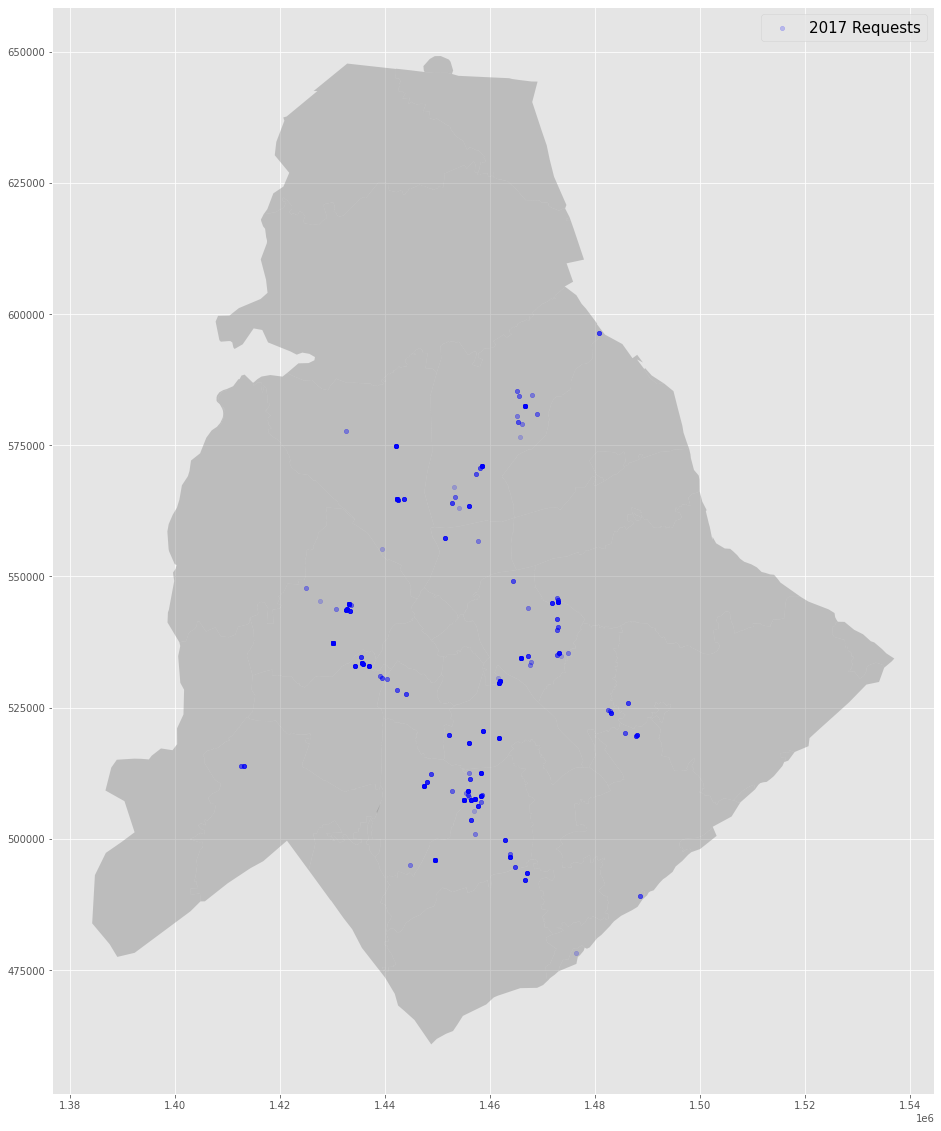

In [26]:
#now let's try to plot the map and see if we get any points on there 

fig,ax = plt.subplots(figsize = (20,20))
charlotte_zipcode_map.plot(ax= ax, alpha =0.4, color ='grey')
geo_requests[geo_requests['BLOCK_NO'] == 3601.0].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = '2017 Requests', alpha =0.2, aspect=1)
plt.legend(prop={'size': 15})

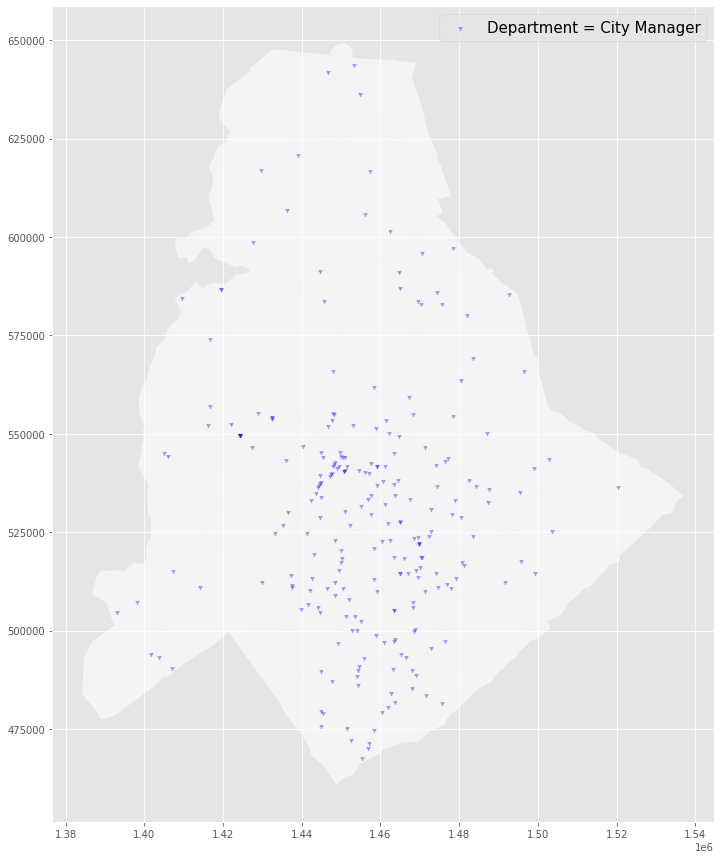

In [50]:
#now let's try to plot the map and see if we get any points on there 

fig,ax = plt.subplots(figsize = (15,15))
charlotte_zipcode_map.plot(ax= ax, alpha =0.6, color ='white')
geo_requests[geo_requests['DEPARTMENT'] == 'City Manager'].plot(ax = ax, markersize = 20, color = 'blue', marker = '1', label = 'Department = City Manager', alpha =0.4, aspect=1)
plt.legend(prop={'size': 15})

In [74]:
geo_requests_subset = geo_requests[0:50]
print(geo_requests_subset)
geo_requests_subset.head()

    OBJECTID  ...                            geometry
0          1  ...  POINT (1458251.00000 508075.00000)
1          2  ...  POINT (1468687.00000 587226.00000)
2          3  ...  POINT (1471481.00000 562513.00000)
3          4  ...  POINT (1438992.00000 568604.00000)
4          5  ...                     POINT (nan nan)
5          6  ...  POINT (1439454.00000 552715.00000)
6          7  ...  POINT (1410991.00000 500986.00000)
7          8  ...  POINT (1401313.00000 495906.00000)
8          9  ...  POINT (1470306.00000 596868.00000)
9         10  ...  POINT (1465887.00000 591565.00000)
10        11  ...  POINT (1431853.00000 561454.00000)
11        12  ...  POINT (1484550.00000 517131.00000)
12        13  ...  POINT (1495596.00000 568170.00000)
13        14  ...  POINT (1475473.00000 558311.00000)
14        15  ...  POINT (1436348.00000 553579.00000)
15        16  ...  POINT (1475667.00000 558868.00000)
16        17  ...  POINT (1461490.00000 481317.00000)
17        18  ...  POINT (14

,OBJECTID,DEPARTMENT,DIVISION,REQUEST_NO,FISCAL_YEAR,FISCAL_MONTH,REQUEST_TYPE,RECEIVED_DATE,INTERNAL_FIELD_OBSERVATION,TITLE,NEIGHBORHOOD_PROFILE_AREA,BLOCK_NO,ZIP_CODE,FULL_ADDRESS,X_COORD,Y_COORD,LATITUDE,LONGITUDE,geometry
0,1,Solid Waste Services,Sanitation,6402056,2017,05-Nov,NON_RECYCLABLE ITEMS,2016/11/07 14:25:00+00,N,NON_RECYCLABLE ITEMS,215.0,3601.0,28226.0,"3601 KNAPDALE LN, CHARLOTTE, NC 28226",1458251.0,508075.0,35.132444,-80.812089,POINT (1458251.00000 508075.00000)
1,2,Housing and NBHD Serv,311 Partner Liaison,6402064,2017,05-Nov,UTILITY VERIFICATION LTR,2016/11/07 14:28:00+00,N,UTILITY VERIFICATION LTR,265.0,4124.0,28269.0,"4124 SILVERMERE WY, CHARLOTTE, NC 28269",1468687.0,587226.0,35.350408,-80.781941,POINT (1468687.00000 587226.00000)
2,3,Solid Waste Services,Sanitation,6402082,2017,05-Nov,NON_RECYCLABLE ITEMS,2016/11/07 14:34:00+00,N,Non-recyclable Items,103.0,523.0,28213.0,"523 GRAHAM MEADOW DR, CHARLOTTE, NC 28213",1471481.0,562513.0,35.282654,-80.771094,POINT (1471481.00000 562513.00000)
3,4,Solid Waste Services,Sanitation,6402103,2017,05-Nov,MISSED RECYCLING,2016/11/07 14:41:00+00,N,MISSED RECYCLING,158.0,1801.0,28216.0,"1801 CRANDON DR, CHARLOTTE, NC 28216",1438992.0,568604.0,35.297745,-80.880327,POINT (1438992.00000 568604.00000)
4,5,Transit,Transit/Operations,6402111,2017,05-Nov,CITIZEN FEEDBACK,2016/11/07 14:44:00+00,N,CITIZEN FEEDBACK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (nan nan)


In [32]:
geo_requests_subset.isnull().sum()


OBJECTID                      0
DEPARTMENT                    0
DIVISION                      0
REQUEST_NO                    0
FISCAL_YEAR                   0
FISCAL_MONTH                  0
REQUEST_TYPE                  0
RECEIVED_DATE                 0
INTERNAL_FIELD_OBSERVATION    0
TITLE                         0
NEIGHBORHOOD_PROFILE_AREA     3
BLOCK_NO                      1
ZIP_CODE                      1
FULL_ADDRESS                  1
X_COORD                       3
Y_COORD                       3
LATITUDE                      3
LONGITUDE                     3
geometry                      0
dtype: int64

In [33]:
#drop missing values 
geo_requests_subset_noNULL = geo_requests.dropna()
geo_requests_subset_noNULL.isnull().sum()


OBJECTID                      0
DEPARTMENT                    0
DIVISION                      0
REQUEST_NO                    0
FISCAL_YEAR                   0
FISCAL_MONTH                  0
REQUEST_TYPE                  0
RECEIVED_DATE                 0
INTERNAL_FIELD_OBSERVATION    0
TITLE                         0
NEIGHBORHOOD_PROFILE_AREA     0
BLOCK_NO                      0
ZIP_CODE                      0
FULL_ADDRESS                  0
X_COORD                       0
Y_COORD                       0
LATITUDE                      0
LONGITUDE                     0
geometry                      0
dtype: int64

**Creating a map using geo_requests_Subset with only the first 50 rows.**


In [59]:
!pip install mapclassify 
import mapclassify
from mapclassify import Quantiles


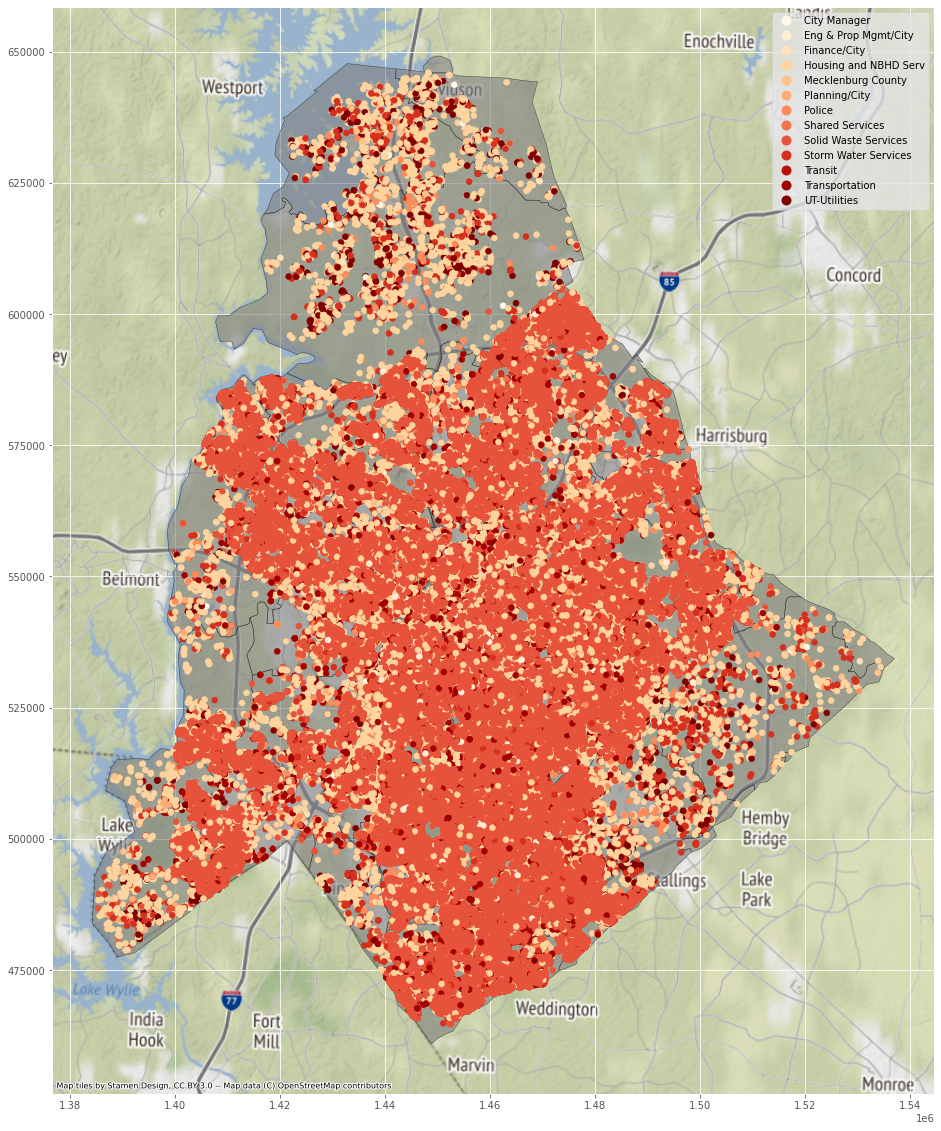

In [81]:
fig,ax = plt.subplots(figsize = (20,20))
charlotte_zipcode_map.plot(ax= ax, color='grey', edgecolor='black', alpha =0.6, lw=0.5)
geo_requests_subset_noNULL.plot(column = 'DEPARTMENT', ax=ax, cmap='OrRd', aspect=1, legend=True)


#adds in the highway background 
ctx.add_basemap(ax, crs=charlotte_zipcode_map.crs.to_string())

In [ ]:
!pip install contextily
import contextily as ctx

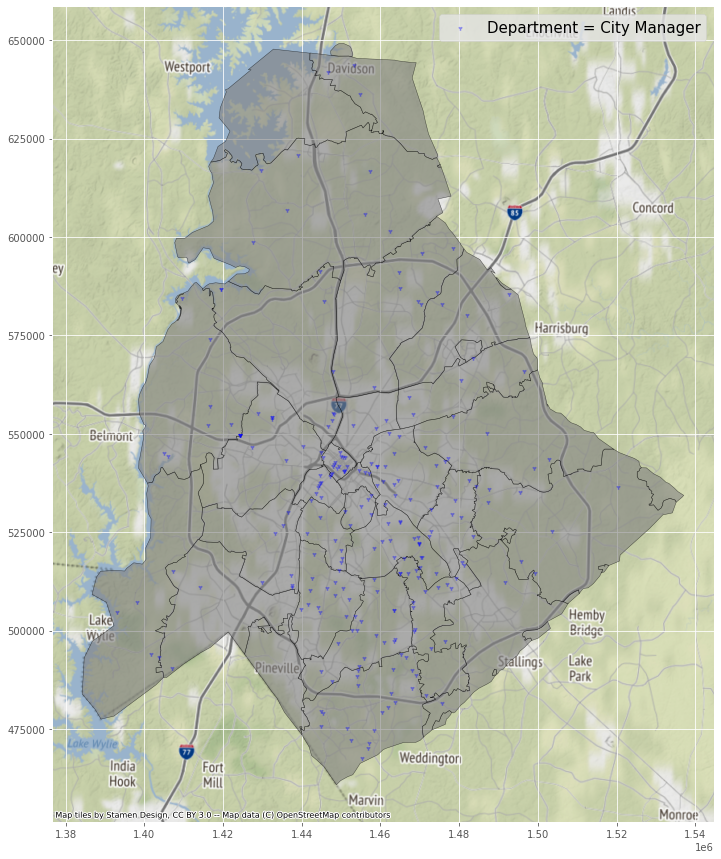

In [80]:
fig,ax = plt.subplots(figsize = (15,15))
charlotte_zipcode_map.plot(ax= ax, color='grey', edgecolor='black', alpha =0.6, lw=0.5)
        

geo_requests[geo_requests['DEPARTMENT'] == 'City Manager'].plot(ax = ax, markersize = 20, color = 'blue', marker = '1', label = 'Department = City Manager', alpha =0.4, aspect=1)
plt.legend(prop={'size': 15})

#adds in the highway background 
ctx.add_basemap(ax, crs=charlotte_zipcode_map.crs.to_string())


In [86]:
print(requests['ZIP_CODE'].value_counts().head(50))


28269.0    147496
28216.0    117044
28208.0    112955
28215.0    112076
28205.0    107186
28277.0     88085
28226.0     85083
28214.0     82944
28210.0     75870
28213.0     70879
28270.0     64466
28212.0     64111
28273.0     57886
28211.0     56663
28227.0     51998
28262.0     49794
28217.0     48851
28209.0     43164
28206.0     31169
28278.0     26350
28203.0     24768
28105.0     18473
28207.0     15137
28202.0     11608
28204.0     10979
28078.0      2203
28134.0      2196
28031.0      1480
28104.0       575
28036.0       457
28272.0       334
282.0         187
28266.0       183
26216.0       168
29745.0       159
28219.0       121
28218.0       113
28201.0        89
28222.0        86
28220.0        77
28223.0        75
28221.0        71
26269.0        67
28295.0        65
28279.0        60
28028.0        58
28263.0        55
28265.0        54
28261.0        48
28025.0        48
Name: ZIP_CODE, dtype: int64


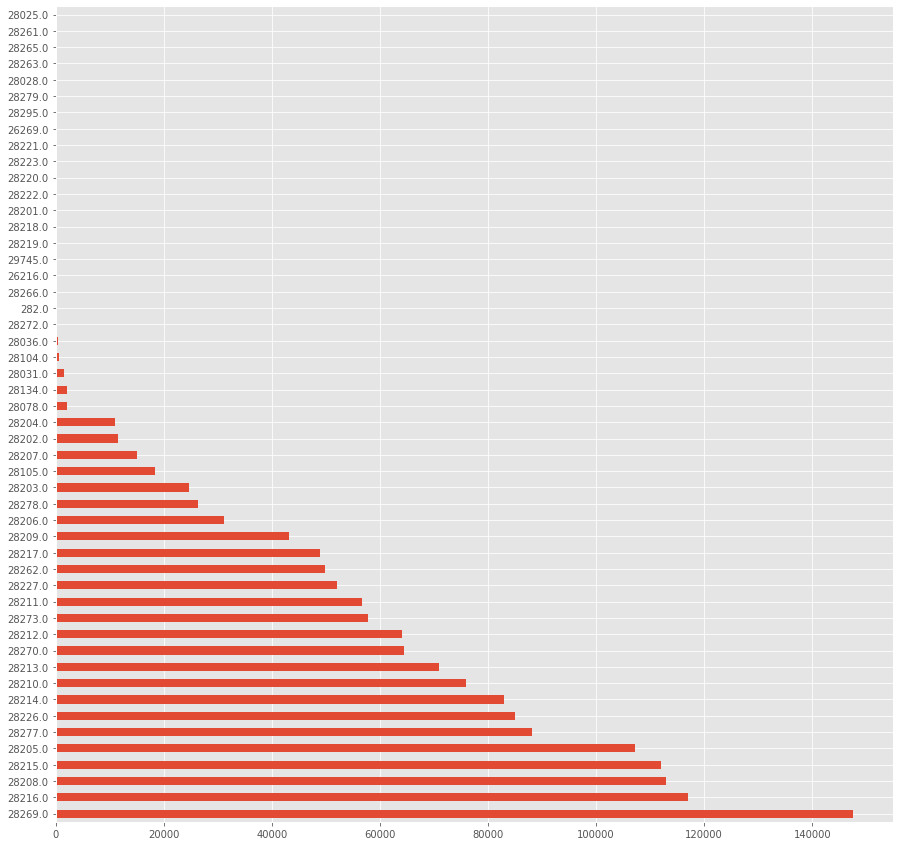

In [88]:
requests['ZIP_CODE'].value_counts().head(50).plot(kind='barh', figsize=(15,15))

In [ ]:
sns.pairplot(requests)

<h2> Data Preprocessing </h2>

<h2> Data Understanding and Exploration </h2>

<h2> Data Preparation for Modeling </h2>

<h2> Modeling </h2>

<h2> Evaluation </h2>

<h2> Results </h2>